# `ml`
> Utility functions that can be used ML jobs and Kaggle.

In [ ]:
#|default_exp ml

Reference for kaggle API: https://github.com/Kaggle/kaggle-api

In [ ]:
#| hide
from nbdev import show_doc, nbdev_export
from fastcore.test import test_fail

In [ ]:
#| export
from __future__ import annotations
from IPython.display import Image, display
from pathlib import Path
from pprint import pprint
from scipy import stats
from scipy.cluster import hierarchy as hc
from typing import Any
from zipfile import ZipFile

import configparser
import datetime as dt
import json
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import shutil
import subprocess

In [ ]:
#| export
def are_features_consistent(
    train_df:pd.DataFrame,   # Training dataset DataFrame 
    test_df:pd.DataFrame, # Testing dataset DataFrame 
    dependent_variables:list(str) = None # List of column name(s) for dependent variables 
)-> bool :  # True if features in train and test datasets are consistent, False otherwise
    """Verifies that features in training and test sets are consistent"""
    if dependent_variables is None:
        features_training_set = train_df.columns
    else:
        features_training_set = train_df.drop(dependent_variables, axis=1).columns
    features_test_set = test_df.columns
    features_diff = set(features_training_set).symmetric_difference(features_test_set)
    if not features_diff == set():
        raise ValueError(f"Discrepancy between training and test feature set: {features_diff}")

    return True

In [ ]:
show_doc(are_features_consistent)

---

[source](https://github.com/vtecftwy/ecutils/blob/master/ecutils/ml.py#L28){target="_blank" style="float:right; font-size:smaller"}

### are_features_consistent



Verifies that features in training and test sets are consistent

Training set and test set should have the same features/columns, except for the dependent variable(s). This function tests whether this is the case.

In [ ]:
feats = [f"Feature_{i:02d}" for i in range(10)]
X_train = pd.DataFrame(np.random.normal(size=(500, 10)), columns=feats)
X_test = pd.DataFrame(np.random.normal(size=(100, 10)), columns=feats)

display(X_train.head(3))
display(X_test.head(3))

,Feature_00,Feature_01,Feature_02,Feature_03,Feature_04,Feature_05,Feature_06,Feature_07,Feature_08,Feature_09
0,0.761104,-0.087520,-1.025924,0.193739,-0.495680,-0.613951,-0.926269,-0.355436,-3.023184,-0.674787
1,-0.221359,-1.192638,0.739712,0.735536,-0.751583,1.498361,0.122651,-0.277625,-0.209543,-1.083627
2,0.354741,0.354827,0.065608,-0.782295,0.893398,-0.058528,-0.580034,0.738977,-0.188675,-0.487240


,Feature_00,Feature_01,Feature_02,Feature_03,Feature_04,Feature_05,Feature_06,Feature_07,Feature_08,Feature_09
0,-0.122319,-0.570185,-0.411036,0.975481,0.916324,-0.903106,0.035641,0.526441,0.198773,0.846844
1,1.362875,0.131076,0.851628,-0.300938,1.501243,0.985879,-0.521996,0.888297,-0.795328,0.461965
2,0.308908,1.909136,1.465560,-0.662192,0.224025,0.215117,1.562526,-0.115224,0.487025,-1.436395


In [ ]:
are_features_consistent(X_train, X_test)

True

In [ ]:
feats[:-1]

['Feature_00',
 'Feature_01',
 'Feature_02',
 'Feature_03',
 'Feature_04',
 'Feature_05',
 'Feature_06',
 'Feature_07',
 'Feature_08']

In [ ]:
are_features_consistent(X_train, X_test[feats[:-2]], dependent_variables=['Feature_08', 'Feature_09'])

True

The function raises a `ValueError` when the features are not compatible, and indicates those features that are not present at both sides:
```ascii
    ValueError: Discrepancy between training and test feature set: {'Feature_09', 'Feature_08'}
```

In [ ]:
test_fail(are_features_consistent, 
          args=(X_train, X_test[feats[:-2]]),
          contains="Discrepancy between training and test feature set:"
         )

In [ ]:
#| export
def cluster_columns(df:pd.DataFrame,  # Multi-feature dataset with column names
                    figsize:tuple(int, int) = (10,6), # Size of the figure
                    font_size:int = 12    # Font size for the chart
                   ):
    """Plot dendogram based on columns' spearman correlation coefficients"""
    corr = np.round(stats.spearmanr(df).correlation, 4)
    corr_condensed = hc.distance.squareform(1-corr)
    z = hc.linkage(corr_condensed, method='average')
    fig = plt.figure(figsize=figsize)
    hc.dendrogram(z, labels=df.columns, orientation='left', leaf_font_size=font_size)
    plt.show()

First seen on fastai repository

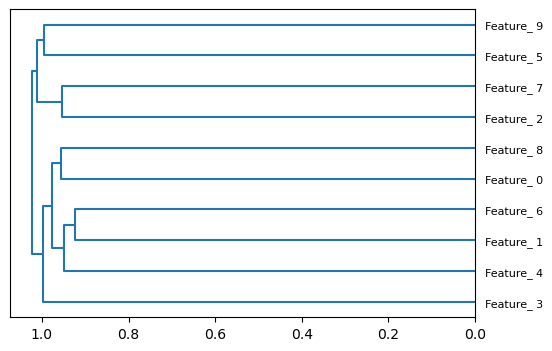

In [ ]:
feats = [f"Feature_{i:2d}" for i in range(10)]
X = pd.DataFrame(np.random.normal(size=(500, 10)), columns=feats)
cluster_columns(X, (6, 4), 8)

In [ ]:
#| export
def run_cli(cmd:str = 'ls -l'   # command to execute in the cli
           ):
    """Wrapper to use subprocess.run with passed command, and print the shell messages"""
    p = subprocess.run(cmd, stdout=subprocess.PIPE, shell=True)
    print(str(p.stdout, 'utf-8'))

In [ ]:
run_cli('pwd')

/home/vtec/projects/ec-packages/ec-utils/nbs-dev



In [ ]:
#| export
def get_config_value(section:str,                        # section in the configparser cfg file
                     key:str,                            # key in the selected section
                     path_to_config_file:Path|str=None   # path to the cfg file
                    )-> Any :                            # the value corresponding to section - key - value 
    """Returns the value corresponding to the key-value pair in the configuration file (configparser format)"""
    if path_to_config_file is None:
        path_to_config_file = Path(f"/content/gdrive/My Drive/config-api-keys.cfg")
    elif isinstance(path_to_config_file, str):
        path_to_config_file = Path(f"/content/gdrive/My Drive/{path_to_config_file}")

    msg = f"Cannot find file {path_to_config_file}. Please check the path or add the config file at that location"
    assert path_to_config_file.is_file(), msg

    configuration = configparser.ConfigParser()
    configuration.read(path_to_config_file)
    return configuration[section][key]

By defaults, it is assumed that the configuration file is saved on google drive. If not, a path to the file (Path or string) must be provided.
The configuration file must be in the format used by the standard module `configparser` [documentation](https://docs.python.org/3/library/configparser.html)

```ascii
    [DEFAULT]
    key = value

    [section_name]
    key = value

    [section_name]
    key = value
```

In [ ]:
path2cfg = Path('../config-sample.cfg').resolve()
assert path2cfg.is_file(), f"{path2cfg} is not a file"

get_config_value(section='azure', key='azure-api-key', path_to_config_file=path2cfg)

'dummy_api_key_for_azure'

In [ ]:
get_config_value(section='wandb', key='api_key', path_to_config_file=path2cfg)

'dummy_api_key_for_wandb'

In [ ]:
#| export
def fastbook_on_colab():
    """Set up environment to run fastbook notebooks for colab"""
    instructions = ['pip install -Uqq fastbook',
                    'wget -O utils.py https://raw.githubusercontent.com/vtecftwy/fastbook/walk-thru/utils.py',
                    'wget -O fastbook_utils.py https://raw.githubusercontent.com/vtecftwy/fastbook/walk-thru/fastbook_utils.py'
                    ]

Code extracted from fastbook notebook:
```python
# Install fastbook and dependencies
!pip install -Uqq fastbook

# Load utilities and install them
!wget -O utils.py https://raw.githubusercontent.com/vtecftwy/fastbook/walk-thru/utils.py
!wget -O fastbook_utils.py https://raw.githubusercontent.com/vtecftwy/fastbook/walk-thru/fastbook_utils.py

from fastbook_utils import *
from utils import *

# Setup My Drive
setup_book()

# Download images and code required for this notebook
import os
os.makedirs('images', exist_ok=True)
!wget -O images/chapter1_cat_example.jpg https://raw.githubusercontent.com/vtecftwy/fastai-course-v4/master/nbs/images/chapter1_cat_example.jpg
!wget -O images/cat-01.jpg https://raw.githubusercontent.com/vtecftwy/fastai-course-v4/walk-thru/nbs/images/cat-01.jpg
!wget -O images/cat-02.jpg https://raw.githubusercontent.com/vtecftwy/fastai-course-v4/walk-thru/nbs/images/cat-02.jpg
!wget -O images/dog-01.jpg https://raw.githubusercontent.com/vtecftwy/fastai-course-v4/walk-thru/nbs/images/dog-01.jpg
!wget -O images/dog-02.jpg https://raw.githubusercontent.com/vtecftwy/fastai-course-v4/walk-thru/nbs/images/dog-01.jpg
```

In [ ]:
#| export
def kaggle_setup_colab(path_to_config_file:Path|str = None      # path to the configuration file (e.g. config.cfg)
                      ):
    """Update kaggle API and create security key json file from config file on Google Drive"""
    # Create API security key file
    path_to_kaggle = Path('/root/.kaggle')
    os.makedirs(path_to_kaggle, exist_ok=True)

    username = get_config_value('kaggle', 'kaggle_username', path_to_config_file=path_to_config_file)
    key = get_config_value('kaggle', 'kaggle_key', path_to_config_file=path_to_config_file)

    api_token = {"username": username, "key": key}
    with open(path_to_kaggle / 'kaggle.json', 'w') as file:
        json.dump(api_token, file)
        os.fchmod(file.fileno(), 600)

    # Update kaggle API software
    run_cli('pip install -Uqq kaggle --upgrade')

References: 
[Kaggle API documentation](https://github.com/Kaggle/kaggle-api)

Kaggle API Token to be placed as a json file at the following location:
```
    ~/.kaggle/kaggle.json
    %HOMEPATH%\.kaggle\kaggle.json
```
To access Kaggle with API, a security key needs to be placed in the correct location on colab.

`config.cfg` file must include the following lines:
```
    [kaggle]
    kaggle_username = kaggle_user_name
    kaggle_key = API key provided by kaggle
```

Info on how to get an api key (kaggle.json) [here](https://github.com/Kaggle/kaggle-api#api-credentials)

In [ ]:
#| export
def kaggle_list_files(code:str = None,          # code for the kaggle competition or dataset
                      mode:str ='competitions'  # mode: `competitions` or `datasets`
                     ):
    """List all files available in the competition or dataset for the passed code"""
    if code is None:
        print(f"code is None, please provide the code of the kaggle competition or dataset")
        return 'Failed'
    elif mode not in ['competitions', 'datasets']:
        print(f"mode must be either 'competitions' or 'datasets', not {mode}")
        return 'Failed'
    else:
        print(f"Listing the files available for {mode}: <{code}>")
        run_cli(f"kaggle {mode} files {code}")

    if mode == 'competitions':
        print(f"{'=' * 140}")
        print(f"Make sure to set the parameters for <{code}> in next cell:")
        print(f" - kaggle_project_folder_name: string with name of the project folder")
        print(f" - train_files: list of files to place into the <train> folder")
        print(f" - test_files: list of files to place into the <test> folder")
        print(f" - submit_files: list of files to place into the <submit> folder")
        print(f"{'=' * 140}")

In [ ]:
#| export
def kaggle_download_competition_files(
    competition_code:str = None, 
    train_files:list() = [], 
    test_files:list = [], 
    submit_files:list = [], 
    project_folder:str = 'ds'
    ):
    """download all files for passed competition, unzip them if required, move them to train, test and submit folders

    competition_code: str       code of the kaggle competition
    train_files: list of str    names of files to be moved into train folder
    test_files: list of str     names of files to be moved into test folder
    submit_files: list of str   names of files to be moved into submit folder
    """
    if competition_code is None:
        print(f"competition_code is None, please provide the code of the kaggle competition")
        return 'Failed'
    else:
        list_of_datasets = {'train': train_files,
                            'test': test_files,
                            'submit': submit_files}

        # creating a project directory and set paths
        if not os.path.exists(project_folder):
            os.makedirs(project_folder)

        path2datasets = Path(f"/content/{project_folder}")
        path2datasets_str = str(path2datasets.absolute())

        # download all files from kaggle
        run_cli(f"kaggle competitions download -c {competition_code} -p {path2datasets}")

        print(f"{'=' * 140}")
        print('Downloaded files:')
        for f in [item for item in path2datasets.iterdir() if item.is_file()]:
            print(f" - {f}")
        print(f"{'=' * 140}")

        # Unzip all zipped files
        for f in path2datasets.glob('*.zip'):
            print(f"Unzipping {f.name}")
            zip_f = ZipFile(f)
            zip_f.extractall(path=path2datasets)
            os.remove(f)
        print(f"{'=' * 140}")

        # Move all data files to the correct data folder
        for dataset_folder, files in list_of_datasets.items():
            if not os.path.exists(f'{project_folder}/{dataset_folder}'):
                os.makedirs(f'{project_folder}/{dataset_folder}')

            for f in files:
                print(f"Moving {f} to {dataset_folder}")
                p2f = path2datasets / f
                if p2f.suffix == '.csv':
                    shutil.move(path2datasets / f, path2datasets / dataset_folder / f)
                else:
                    msg = f"Does not support {p2f.name}'s extension {p2f.suffix}"
                    raise RuntimeError(msg)

        print(f"{'=' * 140}")
        print('Done loading Kaggle files and moving them to corresponding folders')

In [ ]:
#| hide
nbdev_export()